In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = ""
assert not cira.auth.check_keys()

symbols = ["ETH/USD", "BCH/USD", "BTC/USD"]
prices = pd.DataFrame()
for sym in symbols: 
    SYMBOL = sym 
    SYM_HIST_FILE = f'./{sym.replace("/", "_")}.csv'

    stk = cira.Cryptocurrency(sym)

    if not exists(SYM_HIST_FILE): # chacheing historical data  
        start = datetime(2021, 1, 1).date()
        end = datetime.now().date()
        stk.save_historical_data(SYM_HIST_FILE, start, end)

    data = stk.load_historical_data(SYM_HIST_FILE)
    prices[sym.split("/")[0]] = data["open"]

#prices["USD"] = 1.0
#annual_inflation_rate = 0.033  # 3.3%

# Convert the annual inflation rate to a daily inflation rate
#daily_inflation_rate = np.power(1 + annual_inflation_rate, 1/365) - 1

#prices['USD'] = prices['USD'] * (1 - daily_inflation_rate) ** np.arange(len(prices))
prices.head()

,ETH,BCH,BTC
timestamp,,,
2021-01-01 06:00:00+00:00,742.15,350.41,29255.71
2021-01-02 06:00:00+00:00,735.29,342.10,29678.34
2021-01-03 06:00:00+00:00,786.64,359.00,33769.52
2021-01-04 06:00:00+00:00,1086.86,442.44,32907.36
2021-01-05 06:00:00+00:00,992.00,391.81,30461.84


<Axes: xlabel='timestamp'>

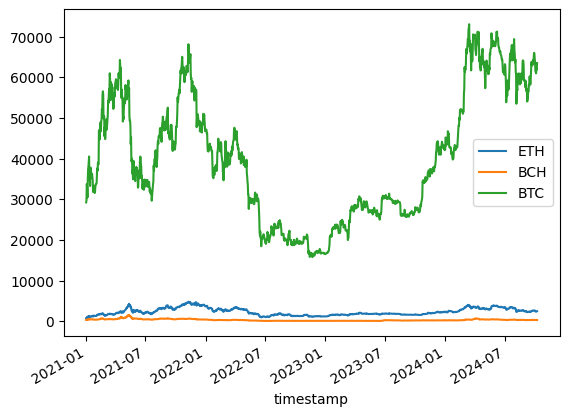

In [2]:
prices.plot()

<Axes: xlabel='timestamp'>

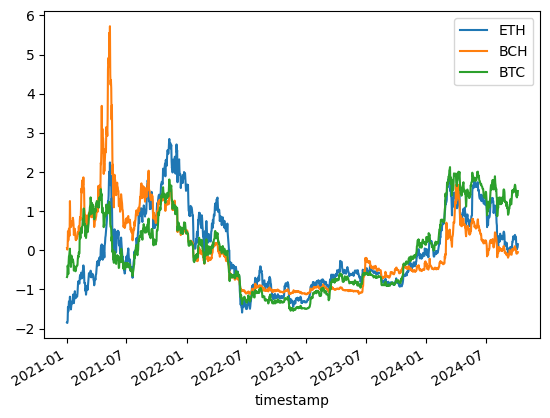

In [3]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
prices_norm = prices.copy()
prices_norm.iloc[:,0:]=scaler.fit_transform(prices_norm.iloc[:,0:].to_numpy())
prices_norm.plot()

In [4]:
split_prc = 0.7
train_data = prices_norm.iloc[:int(len(prices_norm)*split_prc)]
test_data =  prices_norm.iloc[int(len(prices_norm)*split_prc):]
print(len(prices_norm), len(train_data), len(test_data))
assert len(prices_norm) == len(train_data) + len(test_data)

1376 963 413


In [5]:

split_prc = 0.7
train_data_not_norm = prices.iloc[:int(len(prices)*split_prc)]
test_data_not_norm=  prices.iloc[int(len(prices)*split_prc):]
print(len(prices), len(train_data_not_norm), len(test_data_not_norm))
assert len(prices_norm) == len(train_data_not_norm) + len(test_data_not_norm)

1376 963 413


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim



class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Agent:
    def __init__(self, epsilon=0.1):
        self.model = PolicyNetwork()
        self.optimizer = optim.Adam(self.model.parameters())
        self.epsilon = epsilon

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        if np.random.rand() < self.epsilon:
            action = np.random.choice(3)  # choose a random action
        else:
            action_probs = self.model(state)
            action = torch.argmax(action_probs).item()  # choose the best action
        return action
    
    
    def update_policy(self, state, action, reward):
        self.optimizer.zero_grad()
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.model(state)
        loss = -torch.log(action_probs[action]) * reward
        loss.backward()
        self.optimizer.step()


In [7]:

agent = Agent(0.7)
train_data.values

array([[-1.85020063,  0.05600826, -0.68503393],
       [-1.85808033,  0.01734448, -0.65793864],
       [-1.79909747,  0.0959748 , -0.39564844],
       ...,
       [-0.79392879, -0.7019998 , -0.89478269],
       [-0.78828753, -0.70237888, -0.88721308],
       [-0.77756265, -0.69963379, -0.89031885]])

In [8]:
actions = [] 
for t in range(len(train_data)-1):
    state = train_data.iloc[t].values
    action = agent.get_action(state)
    actions.append(action)
    next_state = train_data.iloc[t+1].values
    reward = next_state[action] - state[action]
    agent.update_policy(state, action, reward)
pd.DataFrame({"actions":actions}).value_counts()

actions
2          374
0          359
1          229
Name: count, dtype: int64

In [9]:
from numpy import ndarray
from pandas import DataFrame


class PolicyNetworkStrategy(cira.strategy.Strategy):
    def __init__(self, agent:Agent, allocation_amt = 0.1) -> None:
        super().__init__(name="PolicyNetwork")
        self.agent = agent
        self.allocation_amt = allocation_amt
        self.allocations = []
        self.scaler = preprocessing.StandardScaler()

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash=float) -> ndarray: 

        prices_norm = prices.copy()
        prices_norm.iloc[:,0:]=self.scaler.fit_transform(prices_norm.iloc[:,0:].to_numpy())
        actions = [] 
        for t in range(len(prices_norm)-1):
            state = prices_norm.iloc[t].values
            action = agent.get_action(state)
            actions.append(action)
            next_state = prices_norm.iloc[t+1].values
            reward = next_state[action] - state[action]
            agent.update_policy(state, action, reward)
        _all = np.array([-1,-1,-1])
        if actions == []: 
            pass
        else: 
            action = actions[-1]
            _all[action] = ( cash/prices.iloc[-1].to_list()[action] ) * self.allocation_amt 
        self.allocations.append(_all)
        return _all




<Axes: xlabel='timestamp'>

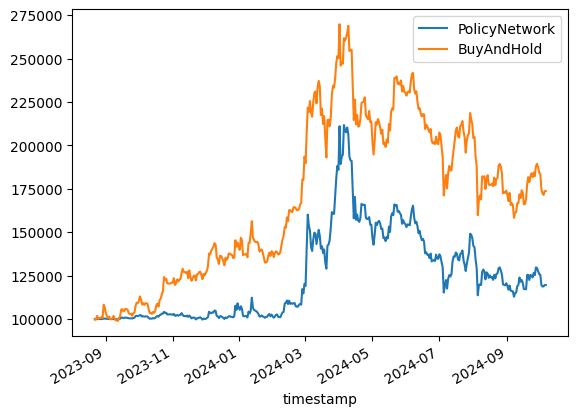

In [10]:
from cira.strategy import back_test_against_buy_and_hold, back_test
strat = PolicyNetworkStrategy(agent, allocation_amt=0.01)
back_test_against_buy_and_hold(strat, test_data_not_norm, test_data_not_norm, 100_000 ).plot()

<Axes: >

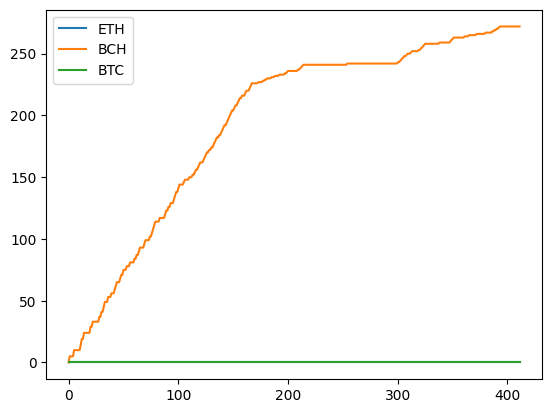

In [11]:
from collections import defaultdict
all_allocations = defaultdict(list)
for _all in strat.allocations:
    for i, sym in enumerate(test_data.keys()):
        all_allocations[sym].append(_all[i])



df_all = pd.DataFrame(all_allocations)
df_all = df_all.cumsum()
df_all.plot()

In [12]:
df_all.value_counts()

ETH  BCH  BTC
0    242  0      46
     241  0      40
     272  0      19
     258  0      13
     259  0      10
                 ..
     190  0       1
     188  0       1
     186  0       1
     180  0       1
     206  0       1
Name: count, Length: 130, dtype: int64